In [2]:
import json
import re
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tqdm import tqdm

In [3]:
def process_string(string):
    string = re.sub('[^A-Za-z0-9\-\/ ]+', ' ', string).split()
    return [y.strip() for y in string]

In [4]:
with open('pos-data-v3.json','r') as fopen:
    dataset = json.load(fopen)

In [5]:
texts, labels = [], []
for i in dataset:
    try:
        texts.append(process_string(i[0])[0].lower())
        labels.append(i[-1])
    except Exception as e:
        print(e, i)

list index out of range ['%', '%', 'SYM']
list index out of range ['%', '%', 'SYM']
list index out of range ['*', '*', 'SYM']
list index out of range ['뭘봐', '뭘봐', 'PROPN']
list index out of range ['%', '%', 'SYM']
list index out of range ['ひ', 'ひ', 'PROPN']
list index out of range ['ヒ', 'ヒ', 'PROPN']
list index out of range ['形聲', '形聲', 'NOUN']
list index out of range ['°', '°', 'SYM']
list index out of range ['汉', '汉', 'PROPN']
list index out of range ['东', '东', 'PROPN']
list index out of range ['王', '王', 'PROPN']
list index out of range ['（', '（', 'PROPN']
list index out of range ['伊', '伊', 'PROPN']
list index out of range ['）', '）', 'PROPN']
list index out of range ['ȝ', 'ȝ', 'PROPN']
list index out of range ['%', '%', 'SYM']
list index out of range ['°', '°', 'SYM']
list index out of range ['%', '%', 'SYM']
list index out of range ["'", '_', 'PROPN']
list index out of range ['碁', '碁', 'NOUN']
list index out of range ['囲碁', '囲碁', 'NOUN']
list index out of range ['*', '*', 'SYM']
lis

In [6]:
word2idx = {'PAD': 0,'NUM':1,'UNK':2}
tag2idx = {'PAD': 0}
char2idx = {'PAD': 0}
word_idx = 3
tag_idx = 1
char_idx = 1

def parse_XY(texts, labels):
    global word2idx, tag2idx, char2idx, word_idx, tag_idx, char_idx
    X, Y = [], []
    for no, text in enumerate(texts):
        text = text.lower()
        tag = labels[no]
        for c in text:
            if c not in char2idx:
                char2idx[c] = char_idx
                char_idx += 1
        if tag not in tag2idx:
            tag2idx[tag] = tag_idx
            tag_idx += 1
        Y.append(tag2idx[tag])
        if text not in word2idx:
            word2idx[text] = word_idx
            word_idx += 1
        X.append(word2idx[text])
    return X, np.array(Y)

In [6]:
X, Y = parse_XY(texts, labels)
idx2word={idx: tag for tag, idx in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [7]:
seq_len = 50
def iter_seq(x):
    return np.array([x[i: i+seq_len] for i in range(0, len(x)-seq_len, 1)])

def to_train_seq(*args):
    return [iter_seq(x) for x in args]

def generate_char_seq(batch):
    x = [[len(idx2word[i]) for i in k] for k in batch]
    maxlen = max([j for i in x for j in i])
    temp = np.zeros((batch.shape[0],batch.shape[1],maxlen),dtype=np.int32)
    for i in range(batch.shape[0]):
        for k in range(batch.shape[1]):
            for no, c in enumerate(idx2word[batch[i,k]]):
                temp[i,k,-1-no] = char2idx[c]
    return temp

In [8]:
X_seq, Y_seq = to_train_seq(X, Y)
X_char_seq = generate_char_seq(X_seq)
X_seq.shape

(103367, 50)

In [9]:
import json
with open('crf-lstm-concat-bidirectional-pos.json','w') as fopen:
    fopen.write(json.dumps({'idx2tag':idx2tag,'idx2word':idx2word,
           'word2idx':word2idx,'tag2idx':tag2idx,'char2idx':char2idx}))

In [10]:
from keras.utils import to_categorical
Y_seq_3d = [to_categorical(i, num_classes=len(tag2idx)) for i in Y_seq]

Using TensorFlow backend.


In [11]:
from sklearn.cross_validation import train_test_split
train_X, test_X, train_Y, test_Y, train_char, test_char = train_test_split(X_seq, Y_seq_3d, X_char_seq, 
                                                                           test_size=0.1)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
import keras
print(keras.__version__)

2.2.2


In [13]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Reshape, Concatenate, Lambda
from keras_contrib.layers import CRF
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
set_session(tf.InteractiveSession())

In [14]:
max_len = seq_len
input_word = Input(shape=(None,))
input_char = Input(shape=(None,None,))
model_char = Embedding(input_dim=len(char2idx) + 1, output_dim=128)(input_char)
s = K.shape(model_char)
def backend_reshape(x):
    return K.reshape(x, (s[0]*s[1],s[2],128))
model_char = Lambda(backend_reshape)(model_char)
model_char = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model_char)
def sliced(x):
    return x[:,-1]
model_char = Lambda(sliced)(model_char)
def backend_reshape(x):
    return K.reshape(x, (s[0],s[1],100))
model_char = Lambda(backend_reshape)(model_char)
model_word = Embedding(input_dim=len(word2idx) + 1, output_dim=64, mask_zero=True)(input_word)
concated_word_char = Concatenate(-1)([model_char,model_word])
model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(concated_word_char)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(len(tag2idx))
output = crf(model)

In [15]:
model = Model(inputs=[input_word, input_char], outputs=output)

In [16]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None)   0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, None, 1 5120        input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 128)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 100)    71600       lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda_2 (

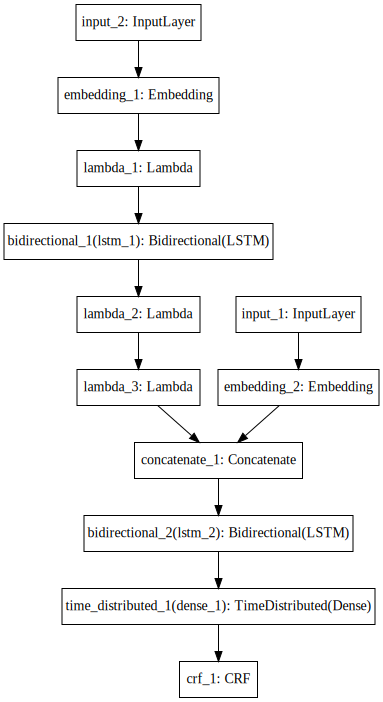

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [19]:
history = model.fit([train_X,train_char], np.array(train_Y), batch_size=32, epochs=2,
                    validation_split=0.1, verbose=1)

Train on 83727 samples, validate on 9303 samples
Epoch 1/2
83727/83727 [==============================] - 765s 9ms/step - loss: 0.1991 - acc: 0.9363 - val_loss: 0.0134 - val_acc: 0.9961
Epoch 2/2
83727/83727 [==============================] - 626s 7ms/step - loss: 0.0089 - acc: 0.9973 - val_loss: 0.0056 - val_acc: 0.9982


In [20]:
predicted=model.predict([test_X,test_char],verbose=1)

10337/10337 [==============================] - 22s 2ms/step


In [21]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
    
pred_labels = pred2label(predicted)
test_labels = pred2label(test_Y)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(np.array(test_labels).ravel(), np.array(pred_labels).ravel()))

             precision    recall  f1-score   support

        ADJ       1.00      1.00      1.00     22803
        ADP       1.00      1.00      1.00     59894
        ADV       1.00      1.00      1.00     23855
        AUX       1.00      1.00      1.00      5232
      CCONJ       1.00      1.00      1.00     18440
        DET       1.00      1.00      1.00     20222
       NOUN       1.00      1.00      1.00    134572
        NUM       1.00      1.00      1.00     21814
       PART       1.00      1.00      1.00      2930
       PRON       1.00      1.00      1.00     23738
      PROPN       1.00      1.00      1.00    113412
      SCONJ       1.00      1.00      1.00      7310
        SYM       1.00      1.00      1.00      1237
       VERB       1.00      1.00      1.00     61167
          X       1.00      0.99      1.00       224

avg / total       1.00      1.00      1.00    516850



In [23]:
model.save_weights('crf-lstm-concat-bidirectional-pos.h5')